# Projet Machine Learning for Time Series : ROCKET

Dans ce notebook on applique l'algorithme ROCKET sur la tache pour laquelle il a été créé : la classification de série temporelle univariée.

**Papiers**

- Rocket paper : https://arxiv.org/pdf/1910.13051

- Rocket official code : https://github.com/angus924/rocket


## Mise en place

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/projet_time_series/"
import os
os.chdir(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run cette cellule, puis redémarrer la session (sans rerun la cellule)
# pour être compatible avec la bibliothèque aeon
#!pip uninstall -y scikit-learn numpy scipy
#!pip install numpy==1.23.5 scikit-learn==1.2.2 scipy==1.10.1

In [ ]:
#!pip install aeon

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Validation de Rocket pour la classification sur le  dataset OliveOil

### Download dataset

In [ ]:
'''
# aeon dataset créé des pb de dépendences avec les autres librairies
# donc on enregistres une fois pour toutes le dataset et ensuite on n'importe plus aeon
from aeon.datasets import load_classification


X, y = load_classification("OliveOil")
print("Shape of X =", X.shape)
print("Shape of y =", y.shape)
X = X.reshape(X.shape[0], X.shape[2])
print("Nouvelle forme de X :", X.shape)

# Enregistrer X et y dans des fichiers pickle
with open("X.pkl", "wb") as f:
    pickle.dump(X, f)
with open("y.pkl", "wb") as f:
    pickle.dump(y, f)
print("Données enregistrées au format pickle.")
'''

'\n# aeon dataset créé des pb de dépendences avec les autres librairies\n# donc on enregistres une fois pour toutes le dataset et ensuite on n\'importe plus aeon\nfrom aeon.datasets import load_classification\n\n\nX, y = load_classification("OliveOil")\nprint("Shape of X =", X.shape)\nprint("Shape of y =", y.shape)\nX = X.reshape(X.shape[0], X.shape[2])\nprint("Nouvelle forme de X :", X.shape)\n\n# Enregistrer X et y dans des fichiers pickle\nwith open("X.pkl", "wb") as f:\n    pickle.dump(X, f)\nwith open("y.pkl", "wb") as f:\n    pickle.dump(y, f)\nprint("Données enregistrées au format pickle.")\n'

In [ ]:
# Charger X et y depuis les fichiers pickle
with open("X.pkl", "rb") as f:
    X = pickle.load(f)
with open("y.pkl", "rb") as f:
    y = pickle.load(f)
print("Données rechargées depuis pickle.")
print("Forme de X chargée :", X.shape)
print("Forme de y chargée :", y.shape)

Données rechargées depuis pickle.
Forme de X chargée : (60, 570)
Forme de y chargée : (60,)


- 60 : Il y a 60 séries temporelles dans le dataset (nombre d'exemples).
- 1 : Chaque série est univariée, c'est-à-dire qu'il y a une seule variable par série temporelle.
- 570 : Chaque série contient 570 points temporels

### Data prepocessing

Normaliser chaque série temporelle individuellement, commen recommandé dans le papier Rocket

In [ ]:
# Normaliser les données
# Initialiser le scaler
scaler = StandardScaler()

# Normaliser chaque série temporelle individuellement
X_normalized = np.zeros_like(X)  # Créer un tableau pour stocker les données normalisées

for i in range(X.shape[0]):  # Parcourir chaque série
    X_normalized[i, :] = scaler.fit_transform(X[i, :].reshape(-1, 1)).flatten()  # Normaliser la série

X = X_normalized.copy()
print("Séries temporelles normalisées !")
print("Forme de X normalisé :", X.shape)

Séries temporelles normalisées !
Forme de X normalisé : (60, 570)


In [ ]:
for i in range(5):  # Vérifier les 5 premières séries
    print(f"Série {i+1}: Moyenne = {X[i, :].mean():.3f}, Écart-type = {X[i, :].std():.3f}")

Série 1: Moyenne = 0.000, Écart-type = 1.000
Série 2: Moyenne = 0.000, Écart-type = 1.000
Série 3: Moyenne = 0.000, Écart-type = 1.000
Série 4: Moyenne = -0.000, Écart-type = 1.000
Série 5: Moyenne = -0.000, Écart-type = 1.000


### Data visualisation rapide

Data visualisation basique. Toutes le séries temporelles se ressemblent. Il est difficile de différencier à l'oeil nu entre les différentes classes.

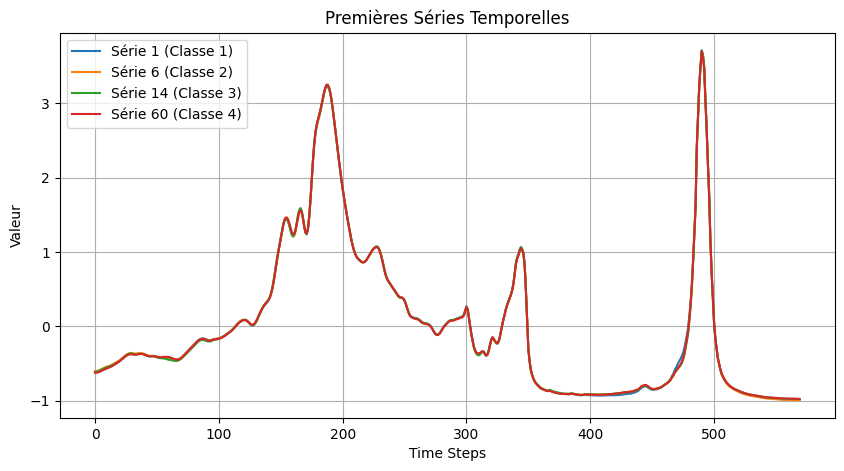

In [ ]:
# Visualiser les 5 premières séries temporelles
idx_to_plot= [0,5,13,59]

plt.figure(figsize=(10, 5))
for i in idx_to_plot:
    plt.plot(X[i, :], label=f'Série {i+1} (Classe {y[i]})')
plt.title('Premières Séries Temporelles')
plt.xlabel('Time Steps')
plt.ylabel('Valeur')
plt.legend()
plt.grid()
plt.show()

### Rocket algorithm


ROCKET attend en entrée plusieurs séries temporelles univariées sous la forme d'une matrice 2D. Il peut être étendu pour traiter plusieurs séries temporelles multivariées

> Texte ci-dessous issu de Rocket paper : https://arxiv.org/pdf/1910.13051

ROCKET transforms time series using convolutional kernels as found in typical convolutional neural networks. The parameters of these kernels are randomly selected as follows:

- **Length:** The length of the kernel is randomly selected from $\{7, 9, 11\}$ with equal probability, ensuring kernels are significantly shorter than input time series in most cases.
    
- **Weights:** The weights $w \in W$ are sampled from a normal distribution $w \sim \mathcal{N}(0, 1)$ and are mean-centered: $\omega = W - \bar{W}$. This ensures that most weights remain relatively small, though larger magnitudes are possible.
    
- **Bias:** The bias $b$ is sampled from a uniform distribution $b \sim \mathcal{U}(-1, 1)$. Only positive values are used in the feature maps. The bias effectively shifts the feature maps above or below zero, emphasizing different aspects of the input data.
    
- **Dilation:** Dilation is sampled exponentially as $d = 2^x$, where $x \sim \mathcal{U}(0, A)$ and $A = \log_2\left(\frac{l_{\text{input}} - 1}{l_{\text{kernel}} - 1}\right)$. This ensures the effective kernel length matches the input time series while allowing kernels to capture patterns at various scales.

- **Padding:** Padding is randomly applied with equal probability. If padding is used, zero-padding is added to the start and end of the series so that the kernel is centered at every point. Without padding, kernels focus on central patterns and may miss patterns at the edges.

**Stride** is always set to one. Nonlinearities such as **ReLU are not applied**, ensuring the resulting feature maps are agnostic to specific transformations. Input time series are assumed to be **normalized** with a mean of zero and a standard deviation of one.

These kernel parameters were determined to optimize classification accuracy on development datasets and generalize well to unseen data.


> Code ci-dessous issu de : https://github.com/angus924/rocket/blob/master/code/rocket_functions.py

In [ ]:
# ROCKET ALGORITHM
###############################
# Angus Dempster, Francois Petitjean, Geoff Webb
#
# @article{dempster_etal_2020,
#   author  = {Dempster, Angus and Petitjean, Fran\c{c}ois and Webb, Geoffrey I},
#   title   = {ROCKET: Exceptionally fast and accurate time classification using random convolutional kernels},
#   year    = {2020},
#   journal = {Data Mining and Knowledge Discovery},
#   doi     = {https://doi.org/10.1007/s10618-020-00701-z}
# }
#
# https://arxiv.org/abs/1910.13051 (preprint)

import numpy as np
from numba import njit, prange

@njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64)")
def generate_kernels(input_length, num_kernels):
    """
    Generates random convolutional kernels as described in the ROCKET paper

    Parameters:
    - input_length: Length of the input time series
    - num_kernels: Number of random kernels to generate

    Returns:
    - weights: Flattened array of kernel weights
    - lengths: Array of kernel lengths (randomly chosen from {7, 9, 11})
    - biases: Array of biases (random values in [-1, 1])
    - dilations: Array of dilation values (sampled on an exponential scale)
    - paddings: Array of padding values (randomly applied)
    """

    # Candidate kernel lengths (ROCKET uses lengths {7, 9, 11})
    candidate_lengths = np.array((7, 9, 11), dtype = np.int32)
    lengths = np.random.choice(candidate_lengths, num_kernels)

    # Initialize arrays for kernel parameters
    weights = np.zeros(lengths.sum(), dtype = np.float64)  # Kernel weights
    biases = np.zeros(num_kernels, dtype = np.float64)     # Kernel biases
    dilations = np.zeros(num_kernels, dtype = np.int32)    # Kernel dilations
    paddings = np.zeros(num_kernels, dtype = np.int32)     # Kernel paddings

    a1 = 0  # Pointer for the start of each kernel's weights

    for i in range(num_kernels):

        _length = lengths[i]  # Length of the current kernel

        # Generate weights from a normal distribution (mean 0, std 1)
        _weights = np.random.normal(0, 1, _length)

        b1 = a1 + _length
        weights[a1:b1] = _weights - _weights.mean()  # Center the weights (mean = 0)

        # Generate bias from a uniform distribution in [-1, 1]
        biases[i] = np.random.uniform(-1, 1)

        # Compute dilation on an exponential scale
        dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1)))
        dilation = np.int32(dilation)
        dilations[i] = dilation

        # Randomly apply padding (0 or centered padding)
        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1  # Move pointer to the next kernel's weights

    return weights, lengths, biases, dilations, paddings

@njit(fastmath = True)
def apply_kernel(X, weights, length, bias, dilation, padding):
    """
    Applies a single convolutional kernel to a time series

    In the code, X represents the input time series, but it is treated as a
    2D matrix, which means it can include univariate or multivariate time series,
    depending on its structure.

    Parameters:
    - X: The input time series of size
    - weights: Weights of the kernel
    - length: Length of the kernel
    - bias: Bias of the kernel
    - dilation: Dilation factor
    - padding: Padding size

    Returns:
    - ppv: Proportion of positive values in the feature map
    - max: Maximum value in the feature map
    """

    input_length = len(X)

    # Compute the output length of the feature map
    output_length = (input_length + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0  # Proportion of positive values
    _max = np.NINF  # Maximum value in the feature map (initialized to negative infinity)

    # Define the range for convolution
    end = (input_length + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):  # Iterate over the time series with padding

        _sum = bias  # Initialize convolution result with the bias

        index = i

        for j in range(length):  # Apply the kernel

            if index > -1 and index < input_length:  # Check if the index is within bounds
                _sum = _sum + weights[j] * X[index]  # Convolve with weights

            index = index + dilation  # Apply dilation

        if _sum > _max:  # Update maximum value
            _max = _sum

        if _sum > 0:  # Count positive values for ppv
            _ppv += 1

    # Return the proportion of positive values and the maximum
    return _ppv / output_length, _max


@njit("float64[:,:](float64[:,:],Tuple((float64[::1],int32[:],float64[:],int32[:],int32[:])))", parallel = True, fastmath = True)
def apply_kernels(X, kernels):
    """
    Applies all generated kernels to a batch of time series

    In the code, X represents the input time series, but it is treated as a
    2D matrix, which means it can include univariate or multivariate time series,
    depending on its structure.

    Parameters:
    - X: A batch of input time series (2D array)
    - kernels: Tuple containing kernel parameters

    Returns:
    - _X: A transformed feature matrix (2 features per kernel: ppv and max)
   """

    weights, lengths, biases, dilations, paddings = kernels

    num_examples, _ = X.shape
    num_kernels = len(lengths)

    # Initialize the output feature matrix
    _X = np.zeros((num_examples, num_kernels * 2), dtype = np.float64)  # Two features per kernel: ppv and max

    for i in prange(num_examples):  # Parallelize over examples

        a1 = 0  # Pointer for weights
        a2 = 0  # Pointer for features

        for j in range(num_kernels):

            b1 = a1 + lengths[j]
            b2 = a2 + 2

            # Apply a single kernel and store the resulting features
            _X[i, a2:b2] = \
            apply_kernel(X[i], weights[a1:b1], lengths[j], biases[j], dilations[j], paddings[j])

            a1 = b1  # Move pointer to the next kernel's weights
            a2 = b2  # Move pointer to the next feature set

    return _X


**Forme de X :**

$X$ est une matrice 2D où :

- Les lignes correspondent aux exemples ou au nombre de séries temporelles dans le dataset (num_examples). Chaque exemple correspond à une série temporelle différente.

- Les colonnes correspondent aux points temporels (input_length)

**ST univariés :** $X$ doit avoir la forme :

`X.shape = (num_examples, input_length)`

**ST multivariées :** $X$ doit avoir la forme :

`X.shape = (num_examples, num_variables, input_length)`

> Actuellement Rocket ne supporte pas les Séries Temporelles Multivariées, mais il est possible de l'adapter pour ce cas.

#### Test de chaque fonction de Rocket

In [ ]:
# Test de generate_kernels
# ---------------------------------
num_kernels = 3
input_length = X.shape[1]
weights, lengths, biases, dilations, paddings = generate_kernels(input_length, num_kernels)

print("weights", weights)
print(f"weights size {len(weights)} = lengths.sum()")
print("lengths", lengths)
print("biases", biases)
print("dilations", dilations)
print("paddings", paddings)

weights [ 0.76044235  0.75802418  2.05464016  0.27919988 -1.15998625 -0.37688577
  0.38519171 -0.86598098 -0.19044149 -1.51686681 -0.12733698  0.21753914
  0.76304462  0.01571278 -0.50922071 -1.03057035  0.65768737  0.13975294
  0.20798584 -0.46193163  0.35220075  0.09213903  1.54865375 -1.95256248
  0.30793046  1.55693485 -1.21083716 -0.78212923 -0.07475872  1.35932967
 -1.19690091]
weights size 31 = lengths.sum()
lengths [11  9 11]
biases [-0.13103003 -0.31972375  0.53837171]
dilations [4 1 5]
paddings [20  4  0]


In [ ]:
# Test de apply_kernels (apply a single kernel)
# ---------------------------------
j = 0
i = 0
a1 = 0
b1 =  a1 + lengths[j]
ppv_kernel, max_kernel = apply_kernel(X[i], weights[a1:b1], lengths[j], biases[j], dilations[j], paddings[j])
print(ppv_kernel, max_kernel)

0.41228070175438597 13.066777867904229


In [ ]:
# Test de apply_kernels
# ---------------------------------
kernels = weights, lengths, biases, dilations, paddings
_X = apply_kernels(X, kernels)
_X.shape # shape : (num_examples, num_kernels*2)

(60, 6)

In [ ]:
# Test de apply_kernels_multivariate
# ---------------------------------
# Dummy data generation
np.random.seed(42)  # Ensure reproducibility

# Parameters for dummy data
num_examples = 5      # Number of time series examples
num_variables = 3     # Number of variables (dimensions) per series
time_length = 50      # Length of each time series

# Generate dummy multivariate time series data
X_dummy = np.random.randn(num_examples, num_variables, time_length)

# Generate random kernels
num_kernels = 10  # Number of kernels to generate
kernels = generate_kernels(time_length, num_kernels)

# Apply kernels to the dummy data
transformed_features = apply_kernels_multivariate(X_dummy, kernels)

# Print shapes and a snippet of the result
print("Input shape (num_examples, num_variables, time_length):", X_dummy.shape)
print("Output shape (num_examples, num_kernels * num_variables * 2):", transformed_features.shape)
print("Transformed features (first example):\n", transformed_features[0])

Input shape (num_examples, num_variables, time_length): (5, 3, 50)
Output shape (num_examples, num_kernels * num_variables * 2): (5, 60)
Transformed features (first example):
 [ 0.5         6.71289545  0.4         5.66722158  0.5         5.66908435
  0.56        5.69418744  0.54        5.98627432  0.52        8.98238586
  0.38        3.92347287  0.36        3.47355326  0.5         4.00453979
  0.42        5.86258602  0.4         5.00939765  0.42        3.80772682
  0.26        1.71636563  0.18        3.18000768  0.28        2.74195555
  0.6         8.45120011  0.6        10.36405744  0.6         9.68800303
  0.36842105  3.15924216  0.36842105  3.63103079  0.34210526  4.15595943
  0.69047619  4.33289676  0.80952381  4.82434801  0.64285714  5.39098233
  0.64        4.66552464  0.58        3.70529154  0.58        4.39276139
  0.18        1.49043913  0.2         0.87250072  0.2         2.40303917]


### Appliquer Rocket sur le jeu de données entier pour la classification


In [ ]:
# Générer 10000 noyaux (typique pour ROCKET)
num_kernels = 10000
input_length = X.shape[1] # Longueur des séries temporelles

kernels = generate_kernels(input_length, num_kernels)
print("Noyaux générés avec succès.")

# Extraire les caractéristiques
X_features = apply_kernels(X, kernels)
print("Forme des features générées :", X_features.shape)

Noyaux générés avec succès.
Forme des features générées : (60, 20000)


In [ ]:
# Clasifier les séries temporelles
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

# Entraîner un RidgeClassifier
model = RidgeClassifier()
model.fit(X_train, y_train)

# Prédire les classes sur les données de test
y_pred = model.predict(X_test)

# Évaluer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision sur l'ensemble de test : {accuracy:.3%}")

Précision sur l'ensemble de test : 88.889%


On constate que Rocket fonctionne plutôt bien sur la classification du Dataset OliveOil atteignant une Accruracy de 88.889%. Rappelons qu'il était difficile de différencier les classes à l'oeil nu.

Nous avons validé le fonctionnement de Rocket sur la classification. Le prochain Notebook testera Rocket sur de la prédicition.